In [1]:
import numpy as np 
import time
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import gc
import cv2

In [2]:
from imaging_functions import show_map, show_map_3d
from noise_functions import perlin_generator, julia, my_perl
from mountains import mountain, voron_mountain
from landscape import landscape_gen

my_landscape = landscape_gen(200,200,num_plates=10,boundaries = True)
print(my_landscape.heights)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46125221636788993, 0.3228972791944399, 0.6690415127305204, 0.2538588186984194, 0.8807323909811174, 0.852523619639621, 0.5099715173329453, 0.9770690659599491, 0.3784331514059427, 0.49567847901507445]


In [177]:
class landscape_gen():
    def __init__(self,lat = 10, long = 10, num_plates = 5, boundaries = True):
        self.lat = lat 
        self.long = long 
        self.lin_sca = math.sqrt(lat*long)
        self.mountains_done = False 
        self.rivers_done = False 
        self.centroids = []
        self.heights =[]
        if boundaries:
            self.centroids = [np.asarray([0,lat]), np.asarray([long,0]),
                              np.asarray([long, lat]), np.asarray([0,0]),
                              np.asarray([0,lat*0.5]), np.asarray([long*0.5,0]),
                              np.asarray([long*0.5, lat]), np.asarray([long, lat*0.5])] #Seafloor tiles on each corner and middles of edges. Redundant if world is made round
            self.heights = [-1.,-1.,-1.,-1.,-1.,-1.,-1.,-1.]
        self.mountains = []
        self.mountains_tiles_x = []
        self.mountains_tiles_y = []
        for i in range (num_plates): 
            new_xy = np.asarray([random.random()*long, random.random()*lat])
            self.centroids.append(new_xy)
            max_height = np.divide(new_xy, [long, lat])
            max_height = np.multiply(max_height, 1 - max_height)
            max_height = np.sum(max_height)
            self.heights.append(max(random.random(),random.random())*4*max_height-1) #To do: scale heights so they're higher in the middle and lower near edges
        self.centroids = np.asarray(self.centroids)      
        
    def get_base_height_old(self, x,y, offset = 1, fine_offset =1, mountainsca=1):

        offset = my_perl.sample(x,y,neg_octaves = 3, octaves=1,ndims=2) * offset ##REFERENCES NOISE, UPDATE AS NECESSARY. Current method with -4 gives range of +-20km (real world ~= 250), each neg_octave doubles this
        fine_offset = my_perl.sample(x,y,neg_octaves = -1, octaves = 4,ndims=3) * fine_offset#Use ndims=3 for hill noise?
        
        fine_x = np.add(x, fine_offset[:,:,0])
        fine_y = np.add(y, fine_offset[:,:,1])
        #fine_pos = np.asarray([x,y])+fine_offset[0:2]
        x += offset[:,:,0]
        y += offset[:,:,1]

        x = np.array(x)
        y = np.array(y)
        #noise_height = offset[2] #Necessary? May cause tiling depending on noise
        xdist = x[:, :, np.newaxis] - self.centroids[:, 0]
        ydist = y[:, :, np.newaxis] - self.centroids[:, 1]
        distances = np.sqrt(xdist**2 + ydist**2)
        
        del xdist
        del ydist
        gc.collect()
        #Find distance for each plate 
        #xdist = np.stack([x for _ in self.centroids])
        #xdist -= np.asarray(my_landscape.centroids)[:,0] #Specify axis for broadcasting? what if shape of x == num of centroids?
        #xdist = np.square(xdist)
        #ydist = np.stack([y for _ in self.centroids])
        #ydist -= np.asarray(my_landscape.centroids)[:,1] #Specify axis for broadcasting? what if shape of x == num of centroids?
        #ydist = np.square(ydist)
        #distances = xdist + ydist
        #distances = np.sqrt(distances)    

        dist_argsort = np.argsort(distances, axis = -1)
        distances = np.sort(distances, axis = -1)
        plate_dist = distances[:,:,0]#Distance to closest plate
        sec_dist = distances[:,:,1]
        third = distances[:,:,2]

        plate_num = dist_argsort[:,:,0]#ID of closest plate
        base_height = np.take(self.heights, plate_num) #Height this ground should be if there were no additional features
        sec_num = dist_argsort[:,:,1] #ID of second closest plate, ID of third not used?
        sec_height = np.take(self.heights, sec_num)
        
        del distances
        del dist_argsort
        gc.collect()
        #TO DO: replace this with calculation of appropriate height that includes subduction

        primary = (base_height + sec_height - 0.8)/1.2 #Mountain ranges or valleys
        #Symmetrical over boundary, raised for high pairs and depressed for low pairs
        #Usual value range is -1 to 1
        bound_weight = 10*np.maximum(third - 2*sec_dist + plate_dist,0)/self.lin_sca
        #How relevant the boundary is, ~= proximity. Should be in the scale 0:1 ish
        sec_weight = (plate_dist - sec_dist)/self.lin_sca #Relative importance of the second plate here, ranges from -1(variable) to 0 (hard maximum)
        secondary = 10*(base_height - sec_height)*sec_weight #DISCONTINUOUS!
        #Subduction. 
        
        #Should be 0 at boundary, and pulse up or down as it goes away
        #Plates higher than neighbour go up, lower go down. Current range is ~-1 to 1, seafloor plates may be more extreme

        boundary_height = (primary + secondary) * bound_weight
        return(boundary_height)
        hill_height = fine_offset[:,:,2] * np.maximum(np.minimum(1,1-bound_weight),0)*0.1
        #Add mountain texture
        boundary_height += mountainsca * np.multiply(np.maximum(boundary_height, 0) , my_perl.sample(fine_x,fine_y,voron=True,neg_octaves=2,octaves=2,ndims=1,fade=0.3)[:,:,0])###IS THIS SCALE CORRECT?)

        #Blur with second plate using weighted sum (weights = sec_weight)
        #Note: Only uses second plate, not third, so will create artifacts around joins of multiple plates
        sec_weight = np.maximum(sec_weight*10,-0.5)
        sec_height = sec_height * (0.5+sec_weight)
        
        
        base_height = base_height * (0.5-sec_weight) + sec_height + boundary_height + hill_height

        
        outer_weight = np.maximum(np.absolute(x - 0.5*self.long)/self.long,0.5, np.absolute(y - 0.5*self.lat)/self.lat)#0.5 inside bounds, increasing as you leave
        outer_weight = np.maximum(1.5 - outer_weight,0) #Causes all height calculations to drop to 0 as you leave the zone
        return(outer_weight*base_height)
    
    
    
    
    def get_base_height(self, x,y, offset = 1, fine_offset =1, mountainsca=1):

        offset = my_perl.sample(x,y,neg_octaves = 4, octaves=4,ndims=2) * offset ##REFERENCES NOISE, UPDATE AS NECESSARY. Current method with -4 gives range of +-20km (real world ~= 250), each neg_octave doubles this
        fine_offset = my_perl.sample(x,y,neg_octaves = -1, octaves = 10,ndims=3) * fine_offset#Use ndims=3 for hill noise?
        
        fine_x = np.add(x, fine_offset[:,:,0])
        fine_y = np.add(y, fine_offset[:,:,1])
        fine_offset = fine_offset[:,:,2]
        #fine_pos = np.asarray([x,y])+fine_offset[0:2]
        x += offset[:,:,0]
        y += offset[:,:,1]

        x = np.array(x)
        y = np.array(y)
        #noise_height = offset[2] #Necessary? May cause tiling depending on noise
        distances = np.sqrt((x[:, :, np.newaxis] - self.centroids[:, 0])**2 + (y[:, :, np.newaxis] - self.centroids[:, 1])**2)

        plate_num = np.argmin(distances, axis = -1)
        plate_dist = np.sort(distances, axis = -1)[:,:,0]#Distance to closest plate
        
        distances = np.subtract(distances, plate_dist[:,:,np.newaxis]) #How much further a plate is than the closest plate
        
        distances = np.minimum(distances, self.lin_sca/10) * 10/self.lin_sca #Cap the distance at 10% of the world size, ranging from 0 to 1
        
        distances = 1 - distances #Weightings of each plate, this is effectively a blurring as you move away and causes primary ridges
        
        boundary_height = np.sum(np.multiply(distances, np.asarray(self.heights)[np.newaxis, np.newaxis, :]), axis = -1)
        #Secondary shape should result in a curve that dips negative, making negative plates cause a ridge on neighbours, mimicking subduction
        distances = np.multiply(distances, np.cos(distances*2*math.pi)) #Current secondary curve method, can be replaced.
        base_height = np.sum(np.multiply(distances, np.asarray(self.heights)[np.newaxis, np.newaxis, :]), axis = -1)
        
        boundary_height = base_height - boundary_height
        base_height = base_height + 0.05*mountainsca * np.multiply(np.maximum(boundary_height, 0) , my_perl.sample(fine_x,fine_y,voron=True,neg_octaves=2,octaves=2,ndims=1,fade=0.3)[:,:,0]) #Add mountain texture
        base_height += np.multiply(2 ** (-1 * base_height**2), fine_offset)*0.5
        return (base_height + boundary_height)
    

        
    
    def get_height(self, x,y,**kwargs):
        height = 0
        base = self.get_base_height(x,y,**kwargs)
        #height += base
        
        return(base) #Currently mountains and rivers are unused, and not adapted for vectorisation
        

In [178]:
my_landscape = landscape_gen(200,200,num_plates=10,boundaries = True)
print(my_landscape.heights)
#my_landscape.heights = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.3562513890557195, 0.8433178635262817, -0.14835264949530602, -0.5807824894940778, -0.2386068573441662, -0.40777518074662567, 0.5199608993359099, -0.4730178884079901, -0.5971038484028552, 0.8943674073691379]
my_landscape.centroids = np.asarray([[  0.        , 200.        ],[200.        ,   0.        ],[200.        , 200.        ],[  0.        ,   0.        ],[  0.        , 100.        ],[100.        ,   0.        ],[100.        , 200.        ],[200.        , 100.        ],
       [ 55.81619914, 106.41546915],[ 66.39202538, 126.70217116],[117.51277566, 101.68669608],[ 13.26238216,  97.41696932],[ 21.16155366, 185.79169227],[147.56209404,  87.05649402],[ 16.64221753,  43.19355469],[111.71320542,   3.72814408],[184.12758595,   0.49181252],[ 48.37360915,  52.13912743]])

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.02011697587018335, -0.7686872139769145, 0.07242998643112464, 0.29789918581387376, 0.15707126865554066, 0.6317295899228594, 0.16231090201278686, 0.02350024843883869, -0.8016918209244634, -0.22000904776553576]


389.02579736709595
(4096, 4096)


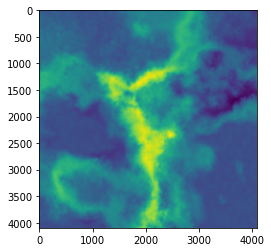

In [192]:
x = y = np.linspace(150-4.096*4,150+4.096*4,4096)
X, Y = np.meshgrid(x,y)

start = time.time()
Z = my_landscape.get_height(X,Y)#, octaves=2,neg_octaves=0, fade=0.5,voron=True,ndims=1)
X, Y = np.meshgrid(x,y)


end = time.time()
print(end-start)
print(Z.shape)
a = Z.min()
b = Z.max()
plt.imshow(Z*0.5 + 0.5)

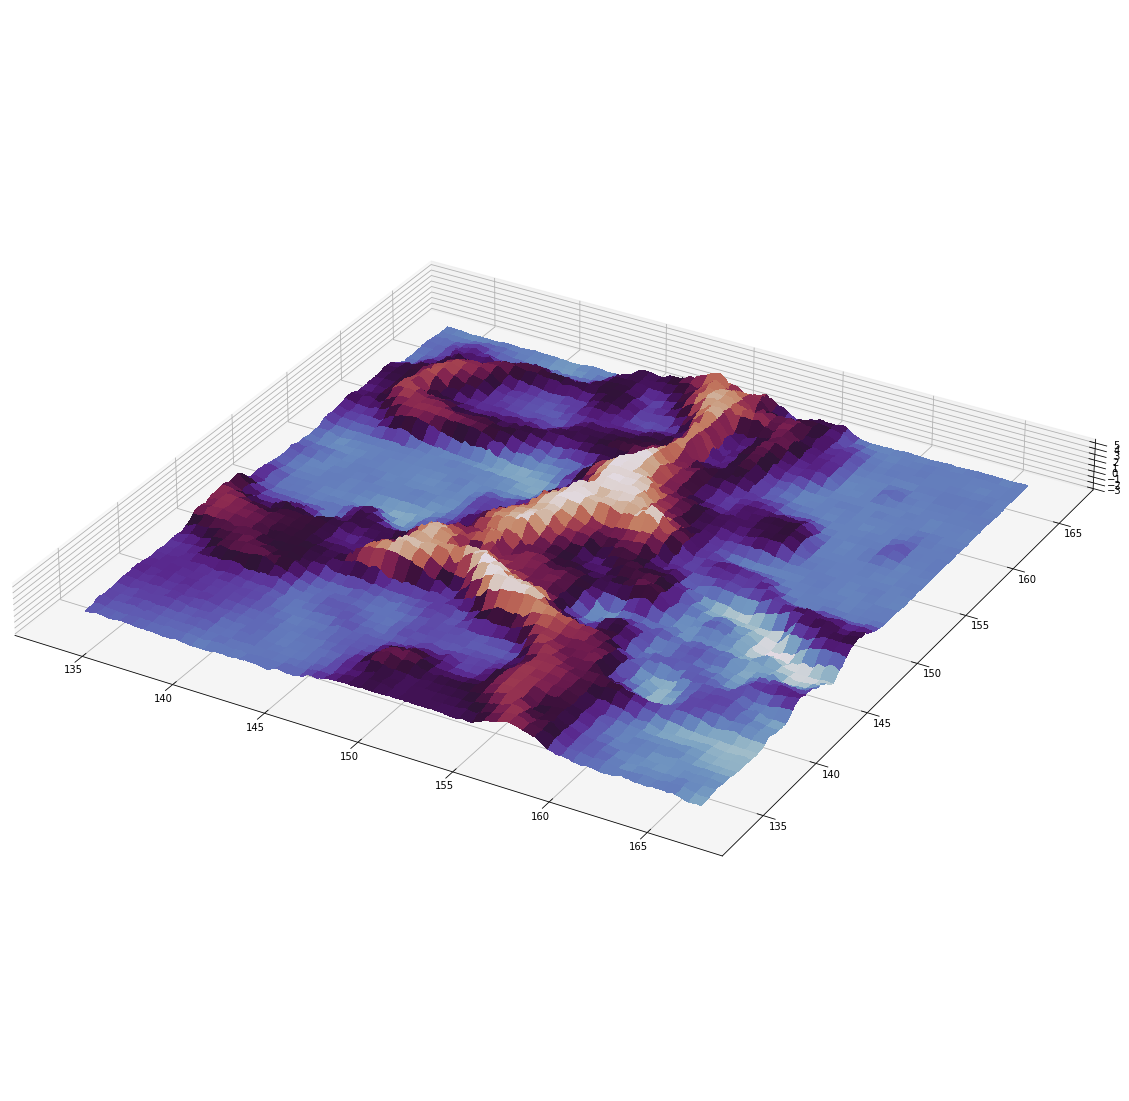

In [193]:
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.075))

#ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

-3.065585170537753
5.47146639186826


True

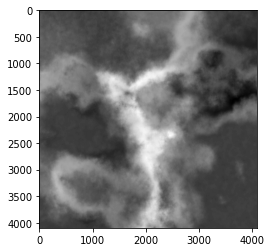

In [194]:
Z = Z + -1 * np.min(Z)
Z = Z /np.max(Z)
Z = Z.astype(np.float32)
print(a)
print(b)
plt.imshow(Z, cmap = "gray")
cv2.imwrite("heightmap10.tiff",Z)#(Z * 255/np.max(Z)))

0.49132442474365234
(256, 256)


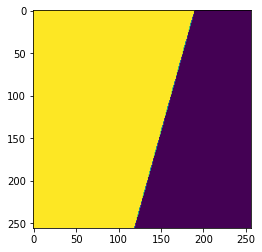

In [63]:
x = y = np.linspace(82.33,82.35,256)
X, Y = np.meshgrid(x,y)

start = time.time()
Z = my_landscape.get_height(X,Y, offset = 0)#, octaves=2,neg_octaves=0, fade=0.5,voron=True,ndims=1)
X, Y = np.meshgrid(x,y)


end = time.time()
print(end-start)
print(Z.shape)
plt.imshow(Z*0.5 + 0.5)

In [ ]:
i = 48
for j in range(14):
    x = y = np.linspace((i+0.5) * 2,200 - (i+0.5) * 2,1024)
    x += (j+1) * 0.5
    X, Y = np.meshgrid(x,y)

    Z = my_landscape.get_height(X,Y)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
    ax.set_box_aspect((1,1,0.075))

    plt.show()
    plt.savefig(f"mapzoom_{j+48}.png")

In [ ]:
for i in range(49):
    x = y = np.linspace((i+0.5) * 2,200 - (i+0.5) * 2,1024)
    X, Y = np.meshgrid(x,y)

    Z = my_landscape.get_height(X,Y)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
    ax.set_box_aspect((1,1,0.075))

    plt.show()
    plt.savefig(f"mapzoom_{i}.png")

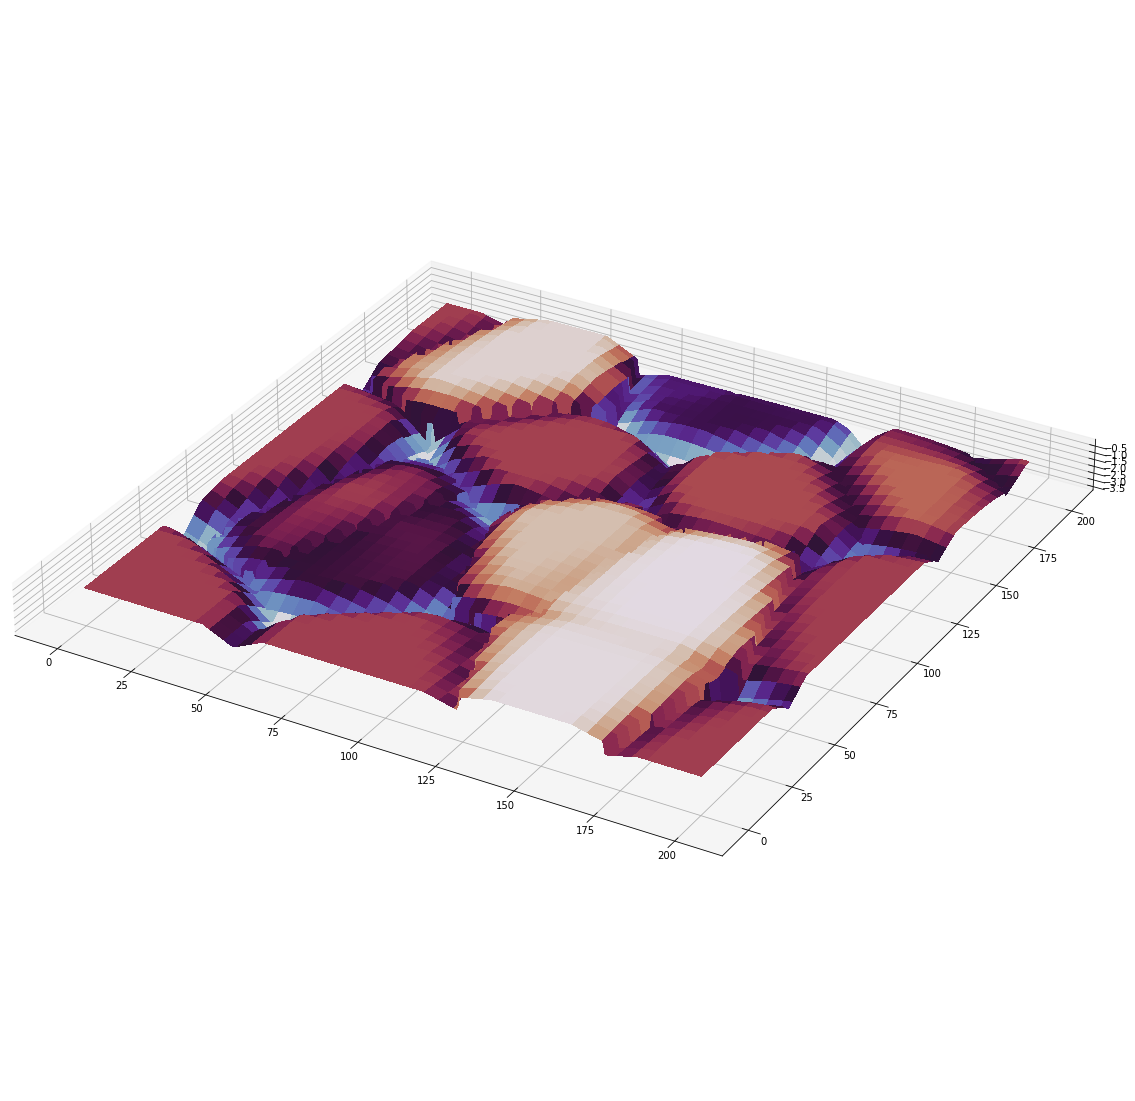

In [5]:

upres=0.1
offs = [10,-10]
scale = 0.2
start = time.time()
X,Y,Z = show_map_3d(my_perl,int(my_landscape.long*upres),int(my_landscape.lat*upres),scale/upres,[my_landscape.long*0.5+offs[0],my_landscape.lat*0.5+offs[1]],vectorised = False, offset=1,fine_offset=1,mountainsca=1)

end = time.time()
print(end-start)

start = time.time()
X,Y,Z2 = show_map_3d(my_perl,int(my_landscape.long*upres),int(my_landscape.lat*upres),scale/upres,[my_landscape.long*0.5+offs[0],my_landscape.lat*0.5+offs[1]],vectorised = True, offset=1,fine_offset=1,mountainsca=1)

end = time.time()
print(end-start)


0.02219247817993164


TypeError: only size-1 arrays can be converted to Python scalars

In [5]:
np.min(Z)

-1.119543917744463

In [6]:
np.max(Z)

11.111403053421286

Large offset not affecting texture of mountains
Fine offset appears to large-scale at neg-oct=0, changed to -1
Lacking finer details (erosion), changed max octaves from 3 to 4
Fine roughness visible (but only as added texture) at resolution of 200m

In [11]:
np.max(Z)

1.0

True

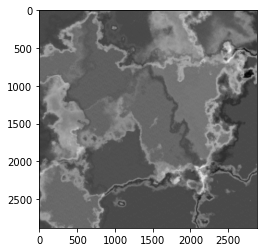

In [183]:
Z = Z + -1 * np.min(Z)
Z = Z /np.max(Z)
Z = Z.astype(np.float32)
plt.imshow(Z, cmap = "gray")
cv2.imwrite("heightmap8.tiff",Z)#(Z * 255/np.max(Z)))

In [ ]:
upres = 10

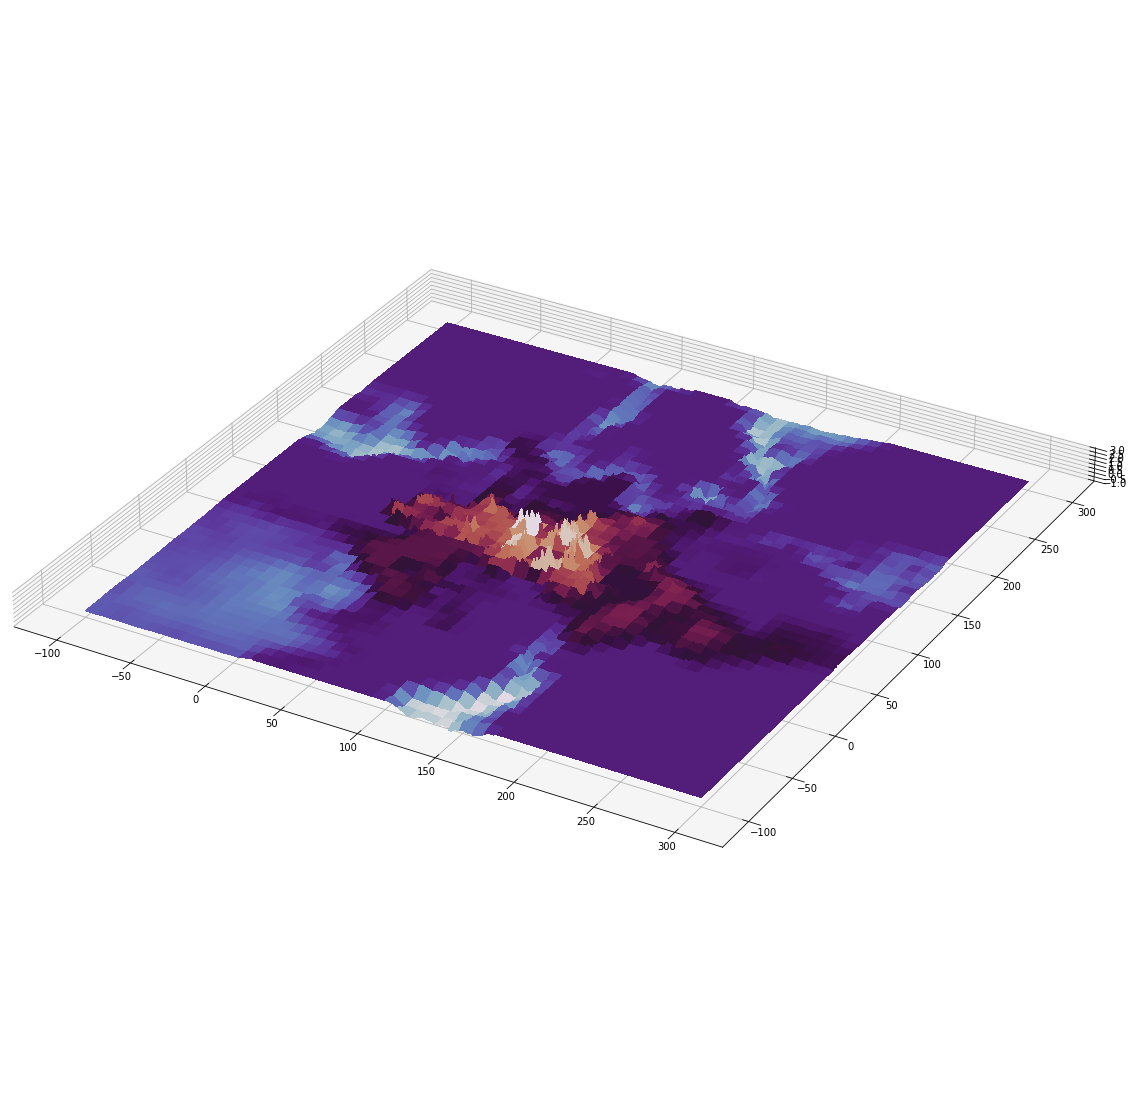

In [248]:

X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),2/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.05))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

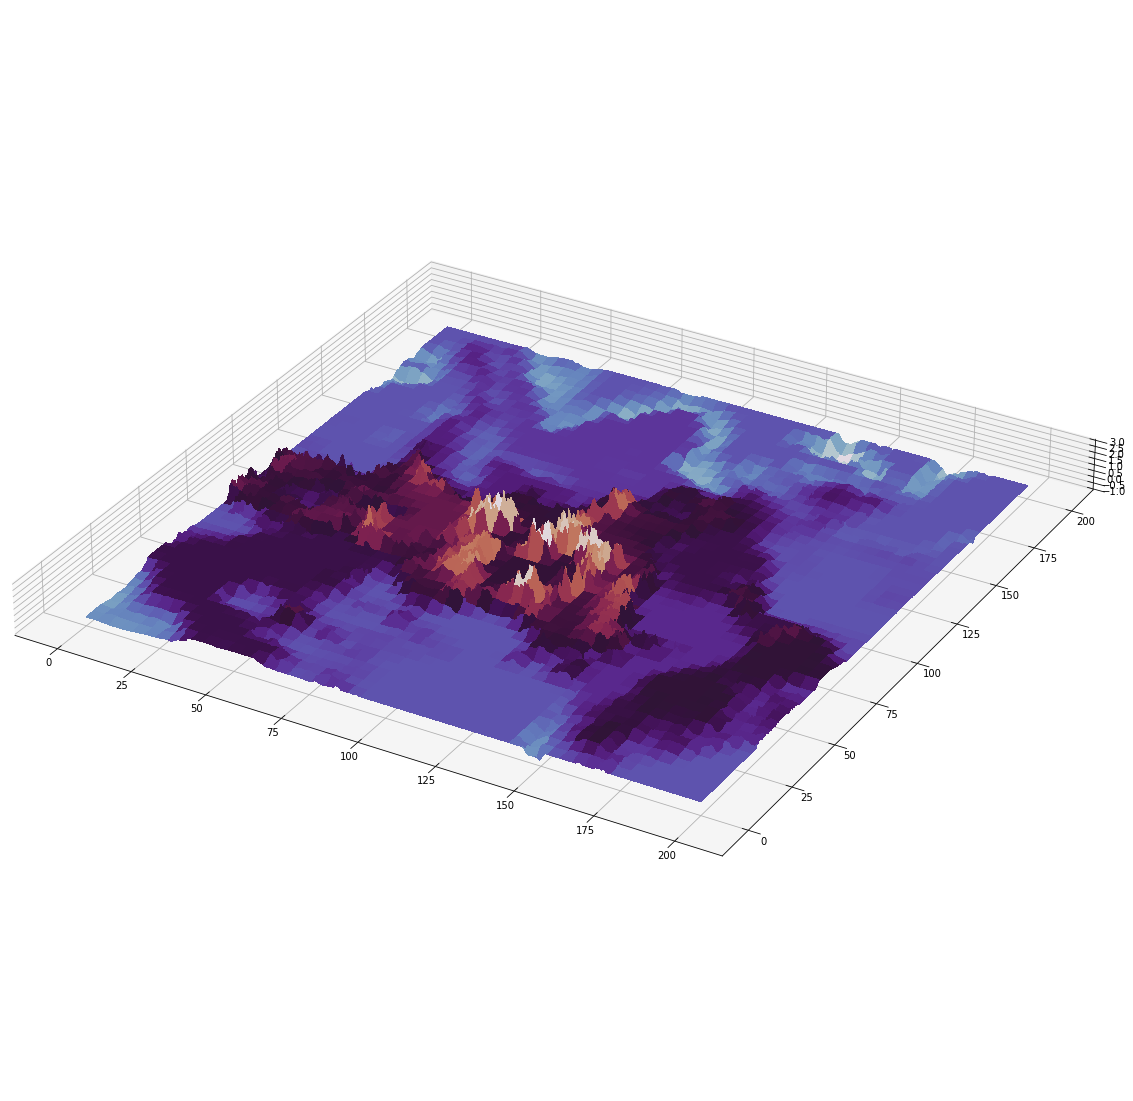

In [249]:
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),1/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])

fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.075))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

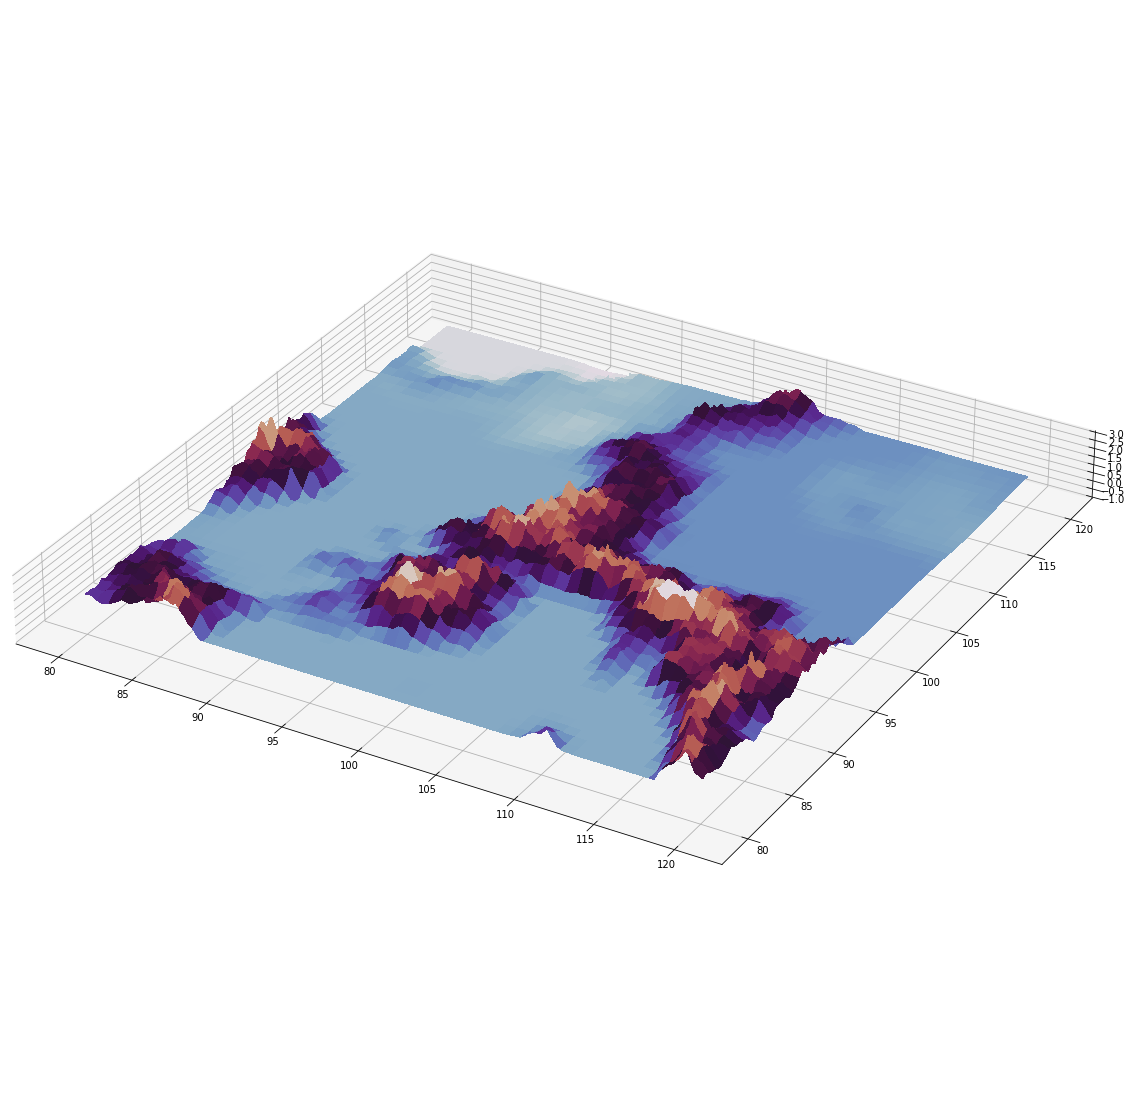

In [250]:
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.2/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])

fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.1))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

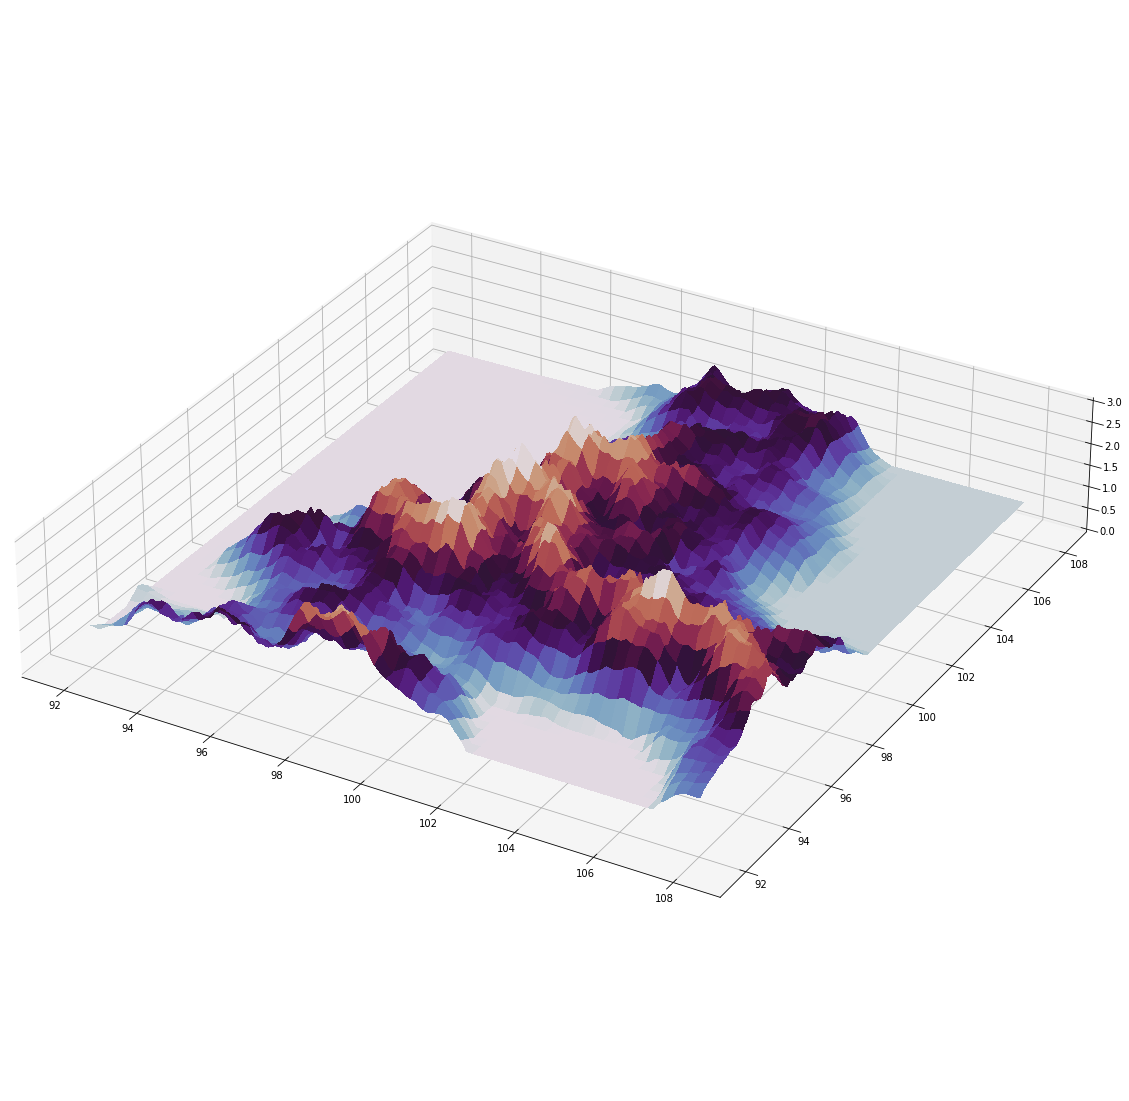

In [251]:
#Slightly Up Close
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.08/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.2))

ax.set_zlim(0,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

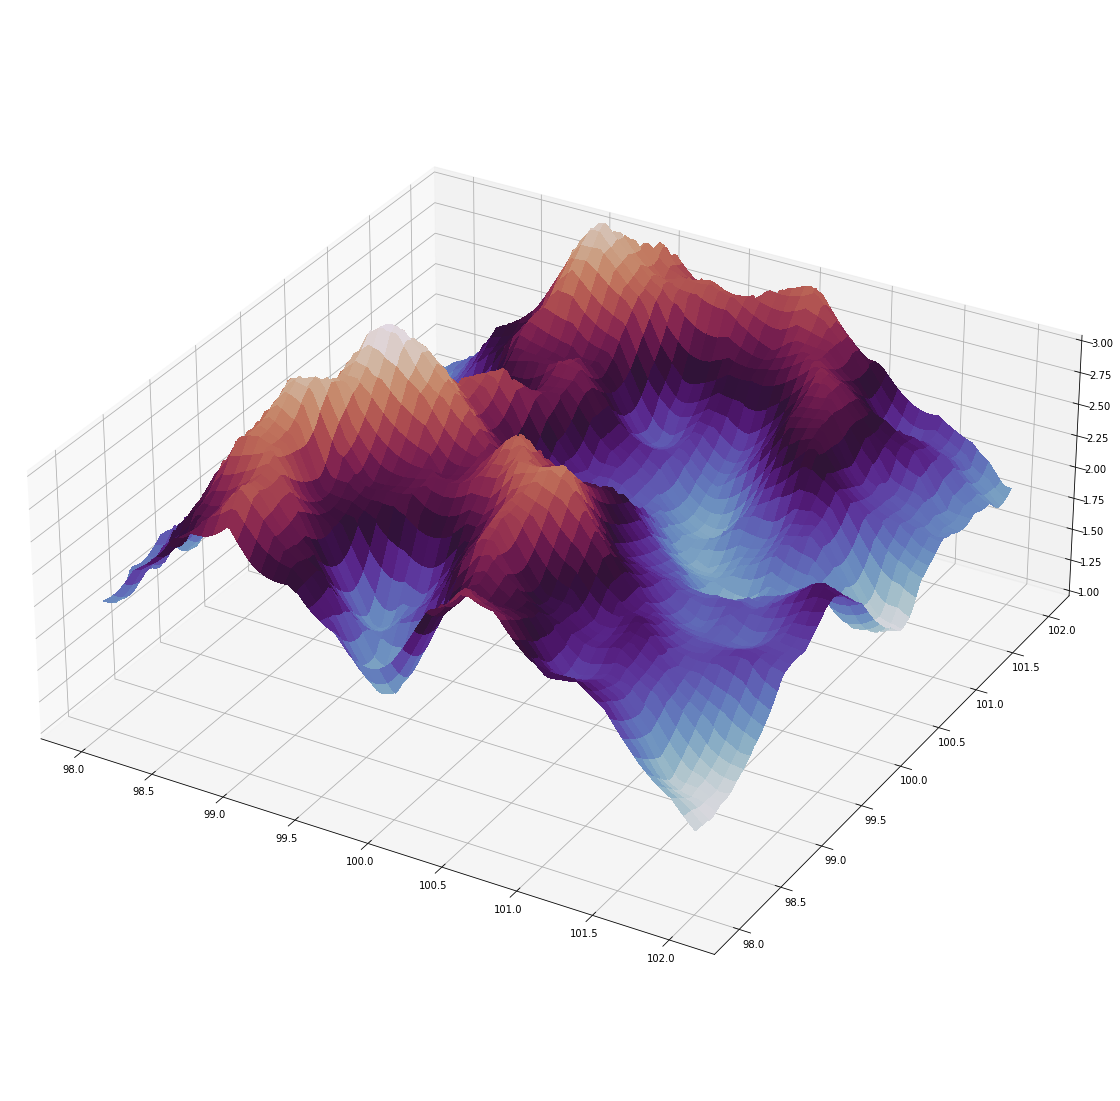

In [252]:
#Up Close
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.02/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.4))

ax.set_zlim(1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

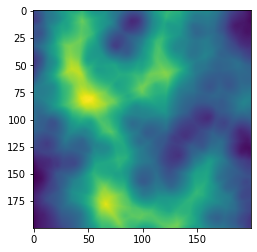

In [228]:
plt.imshow(Z)

In [179]:
my_landscape.centroids

[array([  0, 200]),
 array([100,   0]),
 array([100, 200]),
 array([0, 0]),
 array([  0., 100.]),
 array([50.,  0.]),
 array([ 50., 200.]),
 array([100., 100.]),
 array([89.05212215, 18.09456841]),
 array([ 0.88193504, 30.84390756]),
 array([96.93265666, 30.31454165]),
 array([ 16.47583772, 104.7003559 ]),
 array([17.40071216,  5.49022634]),
 array([ 7.80817072, 85.72547377]),
 array([16.48657516, 23.45700497]),
 array([ 51.24273497, 122.12725281]),
 array([ 92.13250563, 158.83989673]),
 array([ 44.14978359, 101.07777991])]